## Ski Rental with CitiBike
This notebook trains predictors for the rent vs buy problem based on [NYC CitiBike Data](https://citibikenyc.com/system-data)

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
# features
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.neural_network import MLPRegressor


#calibration library
from crepes import WrapRegressor

# metrics
from sklearn.metrics import roc_auc_score
from sklearn import tree

import models as md
import utils as ut
import calibrator as cal
import skirental as sr

%load_ext autoreload 
%autoreload 2

### Section 0: Loading Data

In [152]:
# sampl
n=10000
all_features = ['birth year', 
                'gender', 
                'usertype',
                'starthour',                 
                'start latitude rounded', 
                'start longitude rounded',
                #'end latitude rounded', 
                #'end longitude rounded',
               ]
bike_df = pd.read_csv('clean_data/citibike-june2015.csv').dropna().sample(n)

bike_df = bike_df[bike_df['start station name']!= bike_df['end station name']]
joint_df = bike_df

X = joint_df[all_features]
y = joint_df['tripduration'].values

vec = DictVectorizer()

X_post = vec.fit_transform(X.to_dict('records')).toarray()

### Section 1: Training & Calibrating Predictors
This section is to verify the achievable accuracy / perforamnce of predictors on this dataset

In [15]:
# training calibrated regression model: 
i=0
X_train, X_test, y_train, y_test = train_test_split(
    X_post, y, test_size=0.20, random_state=i)

X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.20, random_state=i)

print(f"size train: {len(X_train)}, valid: {len(X_valid)} test: {len(X_test)} ")

for clf in md.reg_dict: 
    start_time = time.time()
    model = Pipeline(
                [
                    ("scalar", StandardScaler()),
                    ("reg", md.reg_dict[clf]())
                ]
            )
    model.fit(X_train, y_train)
    print(f"{clf} R^2: {model.score(X_test, y_test):.4f}")
    rf = WrapRegressor(model)
    rf.fit(X_train, y_train)
    rf.calibrate(X_valid, y_valid)
    for conf in [0.7, 0.8, 0.9, 0.95]: 
        conf_interval = rf.predict_int(X_test, confidence=conf)
        print(f'conf: {conf:.2f} interval size: {(conf_interval[:, 1] - conf_interval[:, 0]).mean():.2f}')
    end_time = time.time()
    execution_time = end_time - start_time 
    print(f"Function took {execution_time:.4f} seconds to execute\n") 

size train: 6327, valid: 1582 test: 1978 
LR R^2: 0.0169
conf: 0.70 interval size: 770.24
conf: 0.80 interval size: 942.78
conf: 0.90 interval size: 1218.29
conf: 0.95 interval size: 1670.18
Function took 0.0055 seconds to execute

BR R^2: 0.0171
conf: 0.70 interval size: 773.82
conf: 0.80 interval size: 938.56
conf: 0.90 interval size: 1221.69
conf: 0.95 interval size: 1672.09
Function took 0.0074 seconds to execute

XGBR R^2: 0.4115
conf: 0.70 interval size: 535.30
conf: 0.80 interval size: 676.08
conf: 0.90 interval size: 903.35
conf: 0.95 interval size: 1171.19
Function took 1.0376 seconds to execute

SGDR R^2: 0.0168
conf: 0.70 interval size: 773.18
conf: 0.80 interval size: 954.03
conf: 0.90 interval size: 1234.93
conf: 0.95 interval size: 1649.17
Function took 0.0087 seconds to execute

EN R^2: 0.0147
conf: 0.70 interval size: 779.13
conf: 0.80 interval size: 934.55
conf: 0.90 interval size: 1204.53
conf: 0.95 interval size: 1680.44
Function took 0.0041 seconds to execute



In [130]:
training_results = [] 
num_runs = 1
binary_clfs = {} 
calibrators = {} 
bins = 50 
temp_b = 600
for i in range(num_runs): 
        X_train, X_test, y_train, y_test = train_test_split(
            X_post, y>temp_b, test_size=0.20, random_state=i)

        X_train, X_valid, y_train, y_valid = train_test_split(
                X_train, y_train, test_size=0.20, random_state=i)

        for name in md.clf_dict: 
            start_time = time.time()
            curr_clf = md.model_choice(name, X_train, y_train)
            curr_clf.fit(X_train, y_train)
            probs = curr_clf.predict_proba(X_test)[:, 1]
            _, _, ece_l1, ece_l2, alpha, = ut.expected_calibration_error(prob_true=np.asarray(y_test), 
                                                                 prob_pred=np.asarray(probs), 
                                                                 num_bins=bins)
            training_results.append({
                'clf': name, 
                'run': i, 
                'ece_l1': ece_l1, 
                'ece_l2': ece_l2, 
                'alpha': alpha,
                'accuracy': curr_clf.score(X_test, y_test), 
                'auc': roc_auc_score(y_test, probs),
                'calibrated': False
            })
            binary_clfs[name] = curr_clf

            calibrator = cal.BinningCalibrator(bins=bins)
            calibrator.calibrate(curr_clf.predict_proba(X_valid)[:, 1], y_valid)
            y_cal_probs = calibrator.transform(probs)
            _, _, ece_l1, ece_l2, alpha = ut.expected_calibration_error(prob_true=np.asarray(y_test),
                                                                 prob_pred=np.asarray(y_cal_probs),
                                                                 num_bins=bins)
            training_results.append({
                'clf': name, 
                'run': i, 
                'ece_l1': ece_l1, 
                'ece_l2': ece_l2, 
                'alpha': alpha,
                'accuracy': ((y_cal_probs > 0.5) ==  y_test).mean(), 
                'auc': roc_auc_score(y_test, y_cal_probs),
                'calibrated': True
            })
            calibrators[name] = calibrator
            end_time = time.time()
            execution_time = end_time - start_time 
            print(f"{name} took {execution_time:.2f} seconds to execute")

LR took 0.03 seconds to execute
GB took 0.27 seconds to execute
XGB took 0.69 seconds to execute
running model search
KNN took 1.51 seconds to execute
RF took 0.39 seconds to execute
running model search
NN took 6.77 seconds to execute


In [131]:
training_results_df = pd.DataFrame(training_results)

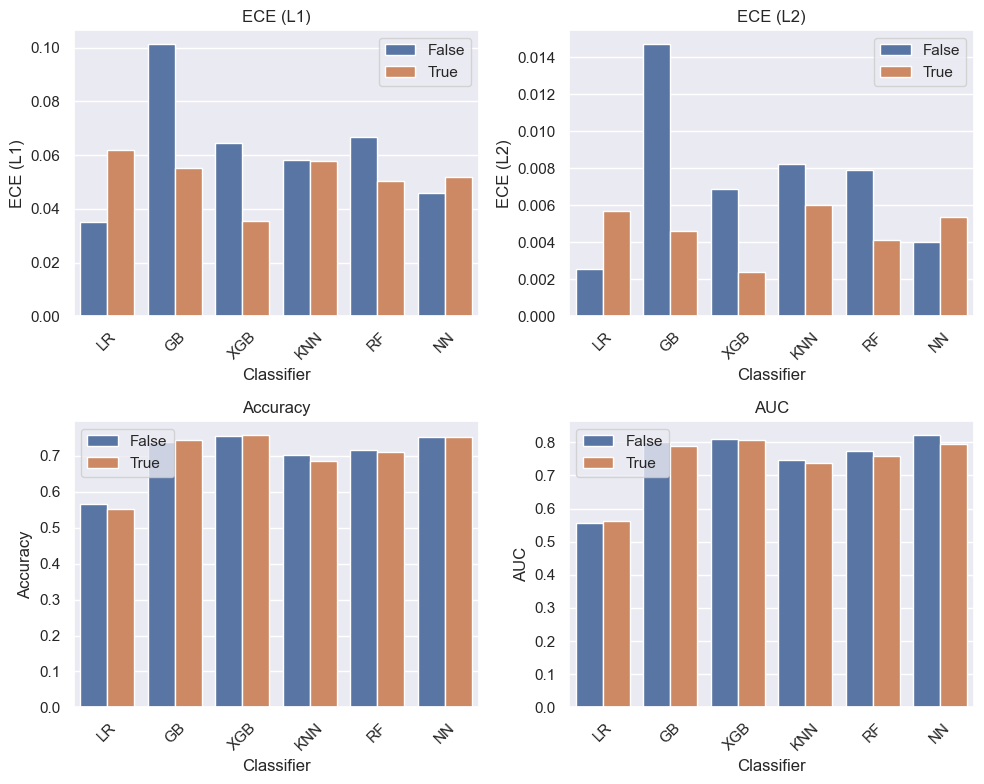

In [132]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
metrics = ['ece_l1', 'ece_l2', 'accuracy', 'auc']
titles = ['ECE (L1)', 'ECE (L2)', 'Accuracy', 'AUC']
axes = axes.ravel()

# Create subplots
for idx, (metric, title) in enumerate(zip(metrics, titles)):
    sns.barplot(
        data=training_results_df,
        x='clf',
        y=metric,
        hue='calibrated',
        ax=axes[idx],
    )
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Classifier')
    axes[idx].set_ylabel(title)
    # Rotate x-axis labels for better readability
    axes[idx].tick_params(axis='x', rotation=45)
    # Move legend to a better position
    axes[idx].legend(title='')

# Adjust layout
plt.tight_layout()
plt.show()

### Section 2: Comparing Ski Rental Algorithms

In [156]:
final_map = {'pip_CR': 'Conformal', 
             'bin_CR': 'Binary', 
             'cal_CR': r'Calibrated', 
             'breakeven_CR': 'Breakeven', 
             6: 'no-info', 
             7: 'partial-info',
             8: 'rich-info',
}

In [153]:
# parameters 
bins=100 # keep bins large so high confidence calibrated predictions exist
num_runs = 5 # number of data splits
conf = 0.9 # interval chosen for conformal experiments
clf_model_name = 'LR' # classification model name
reg_model_name = 'LR' # regression model name

sns.set_style("whitegrid")

for (clf_model_name, reg_model_name) in zip(["LR", "XGB", "NN"], ["LR", "XGBR", "NN"]): 
    debug_dict = {} 
    CR_df = []

    for i in range(num_runs):
        indices = np.arange(len(X))
        # First split: separate out test set (20% of data)
        idx_temp, idx_test = train_test_split(
            indices, test_size=0.20, random_state=i
        )

        # Second split: split remaining data into train and validation (0.25 = 20% of original 80%)
        idx_train, idx_valid = train_test_split(
            idx_temp, test_size=0.20, random_state=i
        )

        # regression 
        X_train = X_post[idx_train]
        X_valid = X_post[idx_valid]
        X_test = X_post[idx_test]

        y_train_cont = y[idx_train]
        y_valid_cont = y[idx_valid]
        y_test_cont = y[idx_test]

        # continuous Y results
        reg_results_df = pd.DataFrame()

        model = md.model_choice_regression(reg_model_name, X_train, y_train_cont)
        rf = WrapRegressor(model)
        rf.fit(X_train, y_train_cont)
        rf.calibrate(X_valid, y_valid_cont)

        conf_interval = rf.predict_int(X_test, confidence=conf)

        reg_results_df['reg_pred_cont'] = model.predict(X_test)
        reg_results_df['reg_low_cont'] = np.maximum(conf_interval[:, 0], 1e-5) # avoid negative numbers
        reg_results_df['reg_high_cont'] = conf_interval[:, 1]
        reg_results_df['y'] = y_test_cont

        for b in [200, 300, 400, 500, 600, 700, 800, 900, 1000]: 
            results_df = pd.DataFrame()

            # discritized y 
            y_train = y_train_cont > b 
            y_valid = y_valid_cont > b 
            y_test = y_test_cont > b 

            # regression with discrete y
            model = md.model_choice_regression(reg_model_name, X_train, y_train)
            model.fit(X_train, y_train)
            reg_model_score = model.score(X_test, y_test)
            rf = WrapRegressor(model)
            rf.fit(X_train, y_train)
            rf.calibrate(X_valid, y_valid)

            conf_interval = rf.predict_int(X_test, confidence=conf)

            results_df['reg_pred'] = model.predict(X_test)
            results_df['reg_low'] = np.maximum(conf_interval[:, 0], 1e-3)
            results_df['reg_high'] = conf_interval[:, 1]


            results_df['y_bin'] = y_test
            results_df['delta'] = 1 - conf

            # classification with binary y 
            curr_clf = md.model_choice(clf_model_name, X_train, y_train)
            curr_clf.fit(X_train, y_train)


            # model probabilities
            probs = curr_clf.predict_proba(X_test)[:, 1]
            valid_probs = curr_clf.predict_proba(X_valid)[:, 1]

            # get opt threshold - balance false positive with false negative 
            fpr, tpr, thresholds = roc_curve(y_valid, valid_probs)
            j_scores = tpr - fpr
            optimal_idx = np.argmax(j_scores)
            optimal_threshold = thresholds[optimal_idx]
            results_df['clf_pred'] =  curr_clf.predict_proba(X_test)[:, 1] >= optimal_threshold
            results_df['eps'] = 1 - (results_df['clf_pred'] == y_test).mean()

            # calibrate model: results are similar for HistogramCalibrator and BinningCalibrator 
            calibrator = cal.HistogramCalibrator(bins=bins)
            calibrator.calibrate(y_prob=valid_probs, 
                                 y_true=y_valid, 
                                subsample=True) # subsample is important for unbalanced classes

            y_cal_probs = calibrator.transform(probs)

            valid_probs = calibrator.transform(valid_probs)
            _, _, _, _, alpha = ut.expected_calibration_error(prob_true=np.asarray(y_valid),
                                                 prob_pred=np.asarray(valid_probs),
                                                 num_bins=bins, 
                                                 subsample=True)

            clf_model_acc = (results_df['clf_pred'] == y_test).mean()

            results_df['clf_prob'] = y_cal_probs
            results_df['alpha'] = alpha
            results_df['b'] = b

            results_df = pd.concat([reg_results_df, results_df], axis=1)

            results_df['pip_cont_day'] = results_df.apply(
                lambda row: sr.pip_alg(u=row['reg_high_cont'],l=row['reg_low_cont'], delta=row['delta'],b=row['b']), axis=1)

            results_df['pip_day'] = results_df.apply(
                lambda row: sr.pip_alg(u=row['reg_high']*b,l=row['reg_low']*b, delta=row['delta'], b=row['b']), axis=1)
            #results_df['pip_day'] = results_df['pip_day']*b

            results_df['bin_day'] = results_df.apply(
                lambda row: sr.regular_ski_rental(pred=row['clf_pred'], eps=row['eps'],b=row['b']), axis=1
            )
            results_df['cal_day'] = results_df.apply(
                lambda row: sr.cal_ski_rental(pred=row['clf_prob'], alpha=row['alpha'], b=row['b']), axis=1
            )
            results_df['breakeven_day'] = b

            results_df['pip_CR'] = sr.get_CR_df(results_df, 'pip_day')
            results_df['pip_cont_CR'] = sr.get_CR_df(results_df, 'pip_cont_day')
            results_df['bin_CR'] = sr.get_CR_df(results_df, 'bin_day')
            results_df['breakeven_CR'] = sr.get_CR_df(results_df, 'breakeven_day')
            results_df['cal_CR'] = sr.get_CR_df(results_df, 'cal_day')

            CR_summary = results_df[['cal_CR', 'bin_CR','pip_CR', 'pip_cont_CR', 'breakeven_CR']].mean().to_dict() 
            CR_summary['b'] = b
            CR_summary['i'] = i
            CR_summary['opt_thresh'] = optimal_threshold

            # add model performance info 
            CR_summary['reg_disc_score'] = reg_model_score
            CR_summary['clf_acc'] = clf_model_acc
            CR_summary['alpha'] = alpha
            CR_df.append(CR_summary)

            if i == 0: 
                debug_dict[b] = results_df.copy()


    CR_df = pd.DataFrame(CR_df)

    melted_df = pd.melt(CR_df, 
                        id_vars=['b', 'i'],
                        value_vars=['pip_CR', 'bin_CR', 'breakeven_CR', 'cal_CR'],
                        var_name='method',
                        value_name='CR')

    melted_df['ALG'] = melted_df['method'].map(final_map)
    sns.lineplot(data=melted_df,
                 x='b',
                 y='CR',
                 hue='ALG',
                 style='ALG',
                 marker='o')  # This will add 95% confidence intervals
    # axes[1].set_title(f'Comparison of CR Methods clf:{clf_model_name} reg:{reg_model_name} (OPT Threshold)')
    feature_str = final_map[len(all_features)]
    plt.xlabel("b (minutes)")
    plt.ylabel(r"$\mathbb{E}[ALG/OPT]$")
    fig.tight_layout()
    plt.savefig(f'img/{feature_str}-clf{clf_model_name}-reg{reg_model_name}_CR-notitle.pdf')
    CR_df.to_csv(f"results/{feature_str}-clf{clf_model_name}-reg{reg_model_name}_CR.csv")
    
    fig.tight_layout()
    plt.title(r'$\mathbb{E}[ALG/OPT]$ for CitiBike Ride Duration (Ski-Rental)' + f'\n clf:{clf_model_name} reg:{reg_model_name} ({" ".join(feature_str.split("-"))})')
    plt.savefig(f'img/{feature_str}-clf{clf_model_name}-reg{reg_model_name}_CR.pdf')
    plt.close()

running model search


/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
 

running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search


/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
 

running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search


/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
 

running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search


/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
 

running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search


/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
 

running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search
running model search


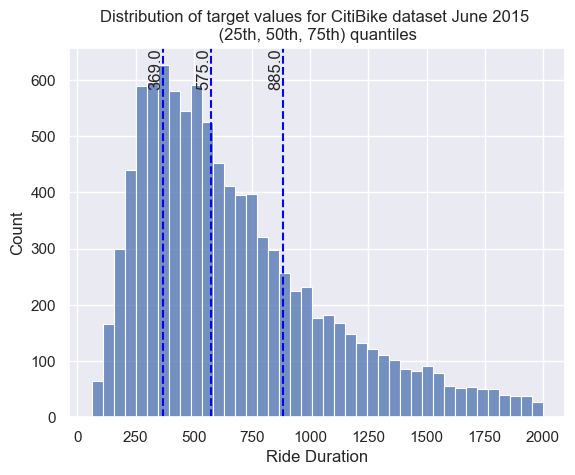

In [38]:
sns.histplot(y)
for q in [0.25, 0.5, 0.75]:
    val = np.quantile(y, q)
    plt.axvline(val, color='blue', linestyle='--')
    plt.text(val, plt.ylim()[1], f'{val}', 
                 rotation=90, va='top', ha='right')
plt.xlabel('Ride Duration')
plt.title(f'Distribution of target values for CitiBike dataset June 2015 \n (25th, 50th, 75th) quantiles ')
plt.savefig('img/bike_distribution.pdf')

In [161]:
# adjusted plots: 
# clf_model_name = 'LR'
# reg_model_name = 'LR'
# feature_str = 'partial-info'
for feature_str in ['partial-info', 'no-info', 'rich-info']: 
    for (clf_model_name, reg_model_name) in zip(["LR", "XGB", "NN"], ["LR", "XGBR", "NN"]): 
        CR_df = pd.read_csv(f"results/{feature_str}-clf{clf_model_name}-reg{reg_model_name}_CR.csv")
        melted_df = pd.melt(CR_df, 
                            id_vars=['b', 'i'],
                            value_vars=['pip_CR', 'bin_CR', 'breakeven_CR', 'cal_CR'],
                            var_name='method',
                            value_name='CR')

        melted_df['ALG'] = melted_df['method'].map(final_map)
        melted_df['b_min'] =  melted_df['b']/60
        plt.figure(figsize=(6, 4)) 
        sns.lineplot(data=melted_df,
                     x='b_min',
                     y='CR',
                     hue='ALG',
                     style='ALG',
                     marker='o')  # This will add 95% confidence intervals
        # axes[1].set_title(f'Comparison of CR Methods clf:{clf_model_name} reg:{reg_model_name} (OPT Threshold)')
        plt.xlabel("Breakeven point (minutes)")
        plt.ylabel(r"$\mathbb{E}[ALG/OPT]$")
        fig.tight_layout()
        plt.savefig(f'img/{feature_str}-clf{clf_model_name}-reg{reg_model_name}_CR-notitle.pdf')

        fig.tight_layout()
        plt.title(r'$\mathbb{E}[ALG/OPT]$ for CitiBike Ride Duration (Ski-Rental)' + f'\n clf:{clf_model_name} reg:{reg_model_name} ({" ".join(feature_str.split("-"))})')
        plt.savefig(f'img/{feature_str}-clf{clf_model_name}-reg{reg_model_name}_CR.pdf')
        plt.close()

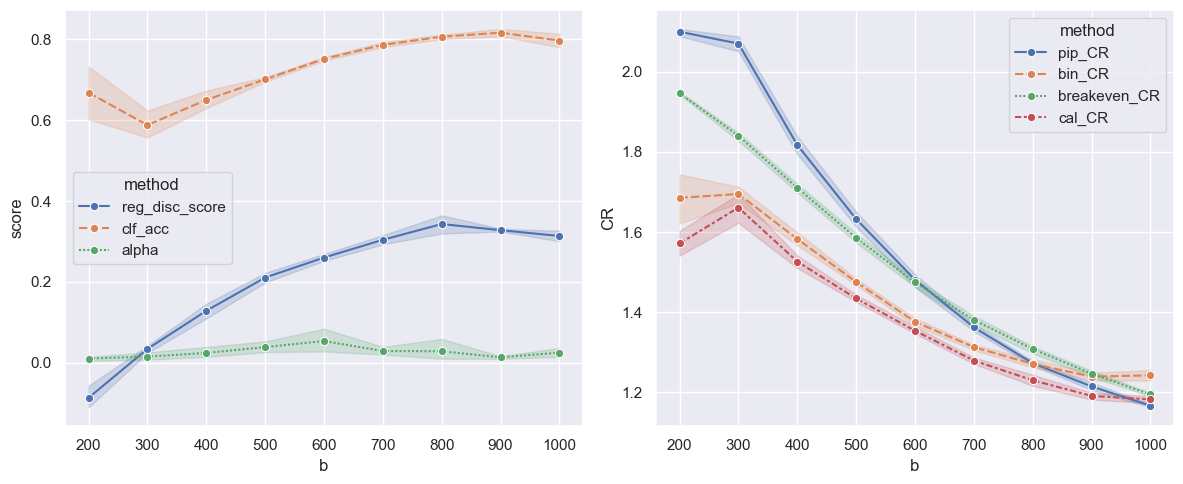

In [105]:
# Melt the DataFrame

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes= axes.flatten() 


# sns.histplot(y, ax=axes[0])
# for q in [0.25, 0.5, 0.75]:
#     val = np.quantile(y, q)
#     axes[0].axvline(val, color='blue', linestyle='--')
#     axes[0].text(val, axes[0].get_ylim()[1], f'{val}', 
#                  rotation=90, va='top', ha='right')
# axes[0].set_xlabel('target value')
# axes[0].set_title(f'Distribution of target values for CitiBike dataset')

melted_df = pd.melt(CR_df, 
                    # Keep b and i as id variables
                    id_vars=['b', 'i'],
                    # Select the CR columns to melt
                    value_vars=['reg_disc_score', 'clf_acc', 'alpha'],
                    #value_vars=['pip_CR', 'bin_CR', 'breakeven_CR', 'cal_CR'],
                    # Name the new columns
                    var_name='method',
                    value_name='score')

sns.lineplot(data=melted_df,
             x='b',
             y='score',
             hue='method',
             style='method',
             marker='o', 
            ax=axes[0])  # This will add 95% confidence intervals

melted_df = pd.melt(CR_df, 
                    id_vars=['b', 'i'],
                    value_vars=['pip_CR', 'bin_CR', 'breakeven_CR', 'cal_CR'],
                    var_name='method',
                    value_name='CR')


sns.lineplot(data=melted_df,
             x='b',
             y='CR',
             hue='method',
             style='method',
             marker='o', 
            ax=axes[1])  # This will add 95% confidence intervals
# axes[1].set_title(f'Comparison of CR Methods clf:{clf_model_name} reg:{reg_model_name} (OPT Threshold)')
plt.savefig(f'clf{clf_model_name}-reg{reg_model_name}_CR.pdf')
fig.tight_layout()

In [99]:
## clf accuracy by feature ablations
all_features = ['birth year', 
                'gender', 
                'usertype',
                'starthour', 
                'start latitude rounded', 
                'start longitude rounded',
                'end latitude rounded', 
                'end longitude rounded',
               ]
    
training_results = [] 
for k in range(len(all_features)-2, len(all_features)+1): 
    selected_features = all_features[:k]
    X = joint_df[selected_features]
    y = joint_df['tripduration'].values

    vec = DictVectorizer()

    X_post = vec.fit_transform(X.to_dict('records')).toarray()
    num_runs = 5
    temp_b = 600
    for i in range(num_runs): 
        X_train, X_test, y_train, y_test = train_test_split(
            X_post, y>temp_b, test_size=0.20, random_state=i)

        X_train, X_valid, y_train, y_valid = train_test_split(
                X_train, y_train, test_size=0.20, random_state=i)

        for name in ["LR", "XGB", "NN"]: 
            curr_clf = md.model_choice(name, X_train, y_train)
            curr_clf.fit(X_train, y_train)
            probs = curr_clf.predict_proba(X_test)[:, 1]
            training_results.append({
                'clf': name, 
                'run': i, 
                'accuracy': curr_clf.score(X_test, y_test), 
                'auc': roc_auc_score(y_test, probs),
                'num_features': len(selected_features)
            })  

running model search
running model search
running model search
running model search
running model search
running model search


/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
 

running model search


/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
 

running model search


/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


running model search


/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
 

running model search


/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
 

running model search


/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
 

running model search


/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
 

running model search


/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
 

running model search


/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


running model search


/Users/jhs/miniforge3/envs/algwpred/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


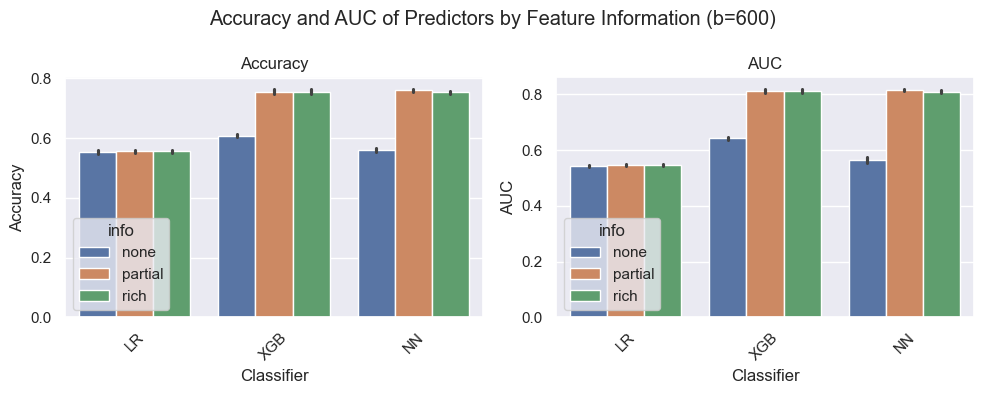

In [102]:
training_results_df = pd.DataFrame(training_results)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
metrics = ['accuracy', 'auc']
titles = ['Accuracy', 'AUC']
axes = axes.ravel()

training_results_df['info'] = training_results_df['num_features'].map({6: 'none', 7:'partial', 8: 'rich'})
# Create subplots
for idx, (metric, title) in enumerate(zip(metrics, titles)):
    sns.barplot(
        data=training_results_df,
        x='clf',
        y=metric,
        hue='info',
        ax=axes[idx],
    )
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Classifier')
    axes[idx].set_ylabel(title)
    # Rotate x-axis labels for better readability
    axes[idx].tick_params(axis='x', rotation=45)
    # Move legend to a better position
    #axes[idx].legend(title='')
    
plt.suptitle(f"Accuracy and AUC of Predictors by Feature Information (b={temp_b})")

# Adjust layout
plt.tight_layout()
plt.savefig('img/feature_acc.pdf')
plt.show()

## Interpreting Differences Between CR

In [ ]:
b=600
results_df = debug_dict[b]

In [ ]:
# debug pip 
row = results_df.iloc[9]
print(row[['pip_cont_CR', 'cal_CR', 'pip_CR']])
print('cal', row['cal_day'], row['clf_prob'], row['reg_high_cont'], row['y'])
print('cont', row['pip_cont_day'], row['reg_low_cont'], row['reg_high_cont'], row['y'])
print('disc', row['pip_day'], row['reg_low']*row['b'], row['reg_high']*row['b'], row['y'])
print(sr.pip_alg(u=row['reg_high_cont'], 
           l=row['reg_low_cont'], 
           delta=row['delta'], 
           b=row['b']))
print(sr.pip_alg(u=row['reg_high']*row['b'], 
           l=row['reg_low']*row['b'], 
           delta=row['delta'], 
           b=row['b']))

# CR 
sr.get_CR(buy=row['pip_day'],
            y=row['y'],
            b=row['b'])

In [ ]:
## compare df 
compare_CR='bin_CR'
compare_day = 'bin_day'
results_df['worse'] = results_df['cal_CR'] > results_df[compare_CR]
results_df['better'] = results_df['cal_CR'] < results_df[compare_CR]

In [ ]:
worst_df = results_df[results_df['worse'] == True]
worst_df.groupby(['cal_CR', 'clf_prob', compare_CR, 'y', 'cal_day', compare_day]).count()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes= axes.flatten() 
sns.histplot(data=results_df, x='cal_day', y=compare_day, ax=axes[0]).set_title("buy day")
sns.histplot(data=results_df, x='cal_CR', y=compare_CR, ax=axes[1]).set_title("CR")
plt.suptitle(f"cal CR vs {compare_CR} for b={b}")